# SPAM E-MAIL Detection Analysis


## Problem statement:

>> This model is used to identify spam emails, so that people don't get those emails which are not useful.   
**Benefits:**   
>> This model will filter spam emails so that customers are remain protected from frauds.   

In [1]:
# importing useful libraries for Data Preparation using nltk, gensim etc.. and Data Visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
import re
import gensim
from gensim import corpora

from gensim.parsing.preprocessing import STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing Data...
df_spam=pd.read_csv('messages.csv')
df_spam

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0
...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0


In [3]:
# checking the features,duplicate values and nan values in the Datasets

print("\nFeatures Present in the Dataset: \n", df_spam.columns)
shape=df_spam.shape
print("\nTotal Number of Rows : ",shape[0])
print("Total Number of Features : ", shape[1])
print("\n\nData Types of Features :\n", df_spam.dtypes)
print("\nDataset contains any NaN/Empty cells : ", df_spam.isnull().values.any())
print("\nTotal number of empty rows in each feature:\n", df_spam.isnull().sum(),"\n\n")
print("Total number of unique values in each feature:")
for col in df_spam.columns.values:
    print("Number of unique values of {} : {}".format(col, df_spam[col].nunique()))
    
print ('\nham and spam counts','\n',df_spam.label.value_counts())



Features Present in the Dataset: 
 Index(['subject', 'message', 'label'], dtype='object')

Total Number of Rows :  2893
Total Number of Features :  3


Data Types of Features :
 subject    object
message    object
label       int64
dtype: object

Dataset contains any NaN/Empty cells :  True

Total number of empty rows in each feature:
 subject    62
message     0
label       0
dtype: int64 


Total number of unique values in each feature:
Number of unique values of subject : 2613
Number of unique values of message : 2859
Number of unique values of label : 2

ham and spam counts 
 0    2412
1     481
Name: label, dtype: int64


In [4]:
# Feature subject is having some null values , in here I am filling the null values using mode() 
# because formal mails always contains subject...
df_spam['subject'].fillna(df_spam['subject'].mode()[0],inplace=True)
df_spam.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [5]:
# Checking if the filling null values process succeded or not...
df_spam['subject'].isna().any()

False

In [6]:
# As we all know that Subject in any Email plays a crucial role whether the Email is formal or Informal, 
# thus here I am joining both subject and mesaage body to get some useful information while training...  
df_spam['Content'] = df_spam[['subject', 'message']].apply(lambda x: ' '.join(x), axis = 1)
df_spam

,subject,message,label,Content
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research center conten...
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0,"sociolinguistics lang classification grimes , ..."
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...
3,risk,a colleague and i are researching the differin...,0,risk a colleague and i are researching the dif...
4,request book information,earlier this morning i was on the phone with a...,0,request book information earlier this morning ...
...,...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1,love your profile - ysuolvpv hello thanks for ...
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1,you have been asked to join kiddin the list ow...
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0,anglicization of composers ' names judging fro...
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0,"re : 6 . 797 , comparative method : n - ary co..."


In [7]:
# New feature (length) contains length of the content feature..
df_spam['length'] = df_spam.Content.str.len()
df_spam.head()

,subject,message,label,Content,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research center conten...,2896
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0,"sociolinguistics lang classification grimes , ...",1817
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...,1486
3,risk,a colleague and i are researching the differin...,0,risk a colleague and i are researching the dif...,329
4,request book information,earlier this morning i was on the phone with a...,0,request book information earlier this morning ...,1071


In [8]:
#     Here I have made a function in which all the Data cleaning steps like removing data which is not useful like 
#      webaddress, email adress, mobile numbers,removing punctuations, converting all the documents into lowercase, 
#           using lemmatization and stemming technique, filtering documents using Stopwords,
#      all these type of data preprocessin steps are being perormed with th ehelp of the function defined below.

stemmer = SnowballStemmer("english")

def Processed_data(email):
    email_corpus = []
    for i in range(0, len(email)):
    # Replace email addresses with 'email'
        review=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress',email[i])
        
    # Replace URLs with 'webaddress'
        review=re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress',review)
        
    # Replace money symbols with 'moneysymb'
        review=re.sub(r'£|\$', 'dollars',review)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
        review=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber',review)
    
    # Replace numbers with 'numbr'
        review=re.sub(r'\d+(\.\d+)?', 'numbr', review)
        
    # getting only words(i.e removing all the special characters)
        review = re.sub(r'[^\w]', ' ', review) 
        
    # getting only words(i.e removing all the" _ ")
        review = re.sub(r'[\_]', ' ', review) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
        review=re.sub(r'\s+[a-zA-Z]\s+', ' ', review)
    
    # Removing extra whitespaces
        review=re.sub(r'\s+', ' ', review, flags=re.I)

    #converting all the letters of the review into lowercase
        review = review.lower()

    # splitting every words from the sentences
        review = review.split()
    
    # iterating through each words and checking if they are stopwords or not,
    # if they are stopwords we will not consider them furthermore and if they are not stopwords then, 
    # performing lemmatization operation on that particular word... 
        review = [stemmer.stem(WordNetLemmatizer().lemmatize(word,pos='v')) for word in review if not word in set(STOPWORDS)]

    # joining the review again
        review = ' '.join(review)
        email_corpus.append(review)
    return email_corpus

In [9]:
# Processing the Data Cleaning Steps on Content feature...
df_spam['Clean_content']=Processed_data(df_spam['Content'])
df_spam.head()

,subject,message,label,Content,length,Clean_content
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research center conten...,2896,job post appl iss research center content leng...
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0,"sociolinguistics lang classification grimes , ...",1817,sociolinguist lang classif grime joseph barbar...
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...,1486,queri letter frequenc text identif post inquir...
3,risk,a colleague and i are researching the differin...,0,risk a colleague and i are researching the dif...,329,risk colleagu research differ degre risk perce...
4,request book information,earlier this morning i was on the phone with a...,0,request book information earlier this morning ...,1071,request book inform earlier morn phone friend ...


In [10]:
# Dropping subject and message features as we don't need them anymore..
df_spam.drop(['subject','message'],axis=1,inplace=True)

In [11]:
# New feature (length) contains length of the Clean_content feature after puncuations,stopwords removal..
df_spam['Clean_length'] = df_spam.Clean_content.str.len()
df_spam.head()

,label,Content,length,Clean_content,Clean_length
0,0,job posting - apple-iss research center conten...,2896,job post appl iss research center content leng...,1657
1,0,"sociolinguistics lang classification grimes , ...",1817,sociolinguist lang classif grime joseph barbar...,1274
2,0,query : letter frequencies for text identifica...,1486,queri letter frequenc text identif post inquir...,889
3,0,risk a colleague and i are researching the dif...,329,risk colleagu research differ degre risk perce...,165
4,0,request book information earlier this morning ...,1071,request book inform earlier morn phone friend ...,505


In [12]:
# Tokenizing Documents..
data=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(df_spam['Clean_content']):
    a=word_tokenize(i,'english')
    data.append(a)

In [13]:
# Makin Word dictionary...
dictionary = corpora.Dictionary(data)
print(dictionary)

Dictionary(43181 unique tokens: ['acoust', 'advantag', 'analysi', 'appl', 'appli']...)


## EDA (Exploratory Data Analysis)

In [14]:
# diplaying number of counts of labels....
df_spam['label'].value_counts()

0    2412
1     481
Name: label, dtype: int64

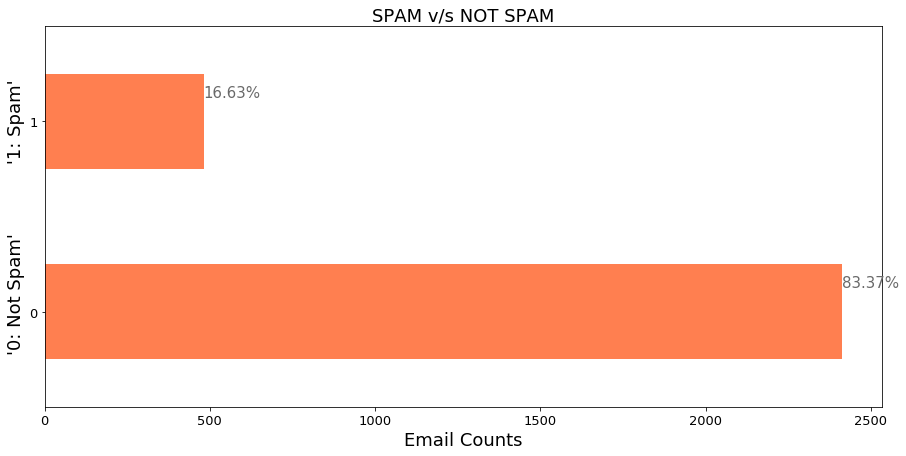

In [15]:
# Displaying the percentage of Spam and Not spam emails in the given dataset...
# Plotting graph using label values from the df_spam dataframe
ax = df_spam['label'].value_counts().plot(kind='barh', figsize=(15,7),color="coral", fontsize=13)
ax.set_alpha(0.8)

# Setting up title and labels
ax.set_title("SPAM v/s NOT SPAM", fontsize=18)
ax.set_xlabel("Email Counts",  fontsize=18)
ax.set_ylabel("'0: Not Spam'            '1: Spam'", fontsize=18)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,color='dimgrey')

In [16]:
#for counting frequently occurence of spam and not spam words.
count1 = Counter(" ".join(df_spam[df_spam['label']==0]["Clean_content"]).split()).most_common(200)
count2 = Counter(" ".join(df_spam[df_spam['label']==1]["Clean_content"]).split()).most_common(200)
df=pd.DataFrame()
print("TOP 200 Words in Each Category (Word,Counts)")
df['Not Spam Words']=count1
df['Spam Words']=count2
df.head(10)

TOP 20 Words in Each Category (Word,Counts)


,Not Spam Words,Spam Words
0,"(numbr, 60389)","(numbr, 15369)"
1,"(languag, 8859)","(dollar, 4670)"
2,"(univers, 6675)","(mail, 1907)"
3,"(linguist, 5943)","(order, 1635)"
4,"(paper, 3894)","(report, 1413)"
5,"(inform, 2859)","(address, 1368)"
6,"(confer, 2846)","(email, 1179)"
7,"(english, 2319)","(program, 1085)"
8,"(workshop, 2199)","(send, 1062)"
9,"(research, 2193)","(list, 982)"


In [17]:
# Making a wordcloud function in order to show the SPAM and NOT SPAM words from the dataset..
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def Display_wordcloud(data,title):
    feedbackcloud = WordCloud(
        background_color = 'black',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 25
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(feedbackcloud)
    plt.title(f"{title} words")
    plt.show()

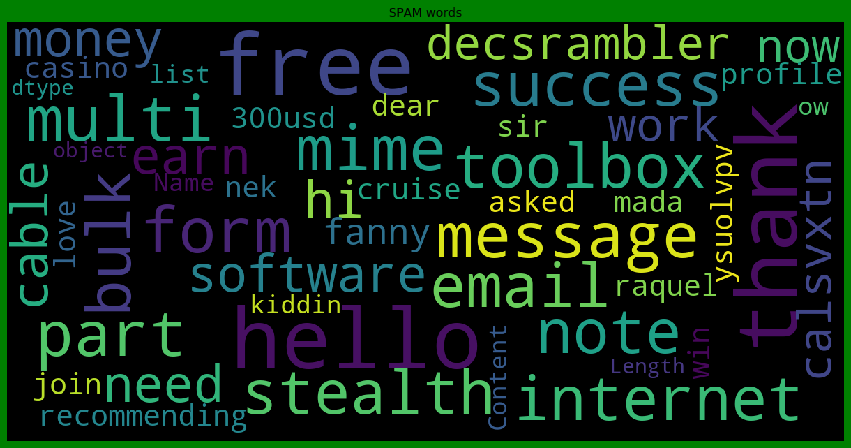

In [18]:
# SPAM words in training data
Display_wordcloud(df_spam['Content'][df_spam['label']==1],"SPAM")

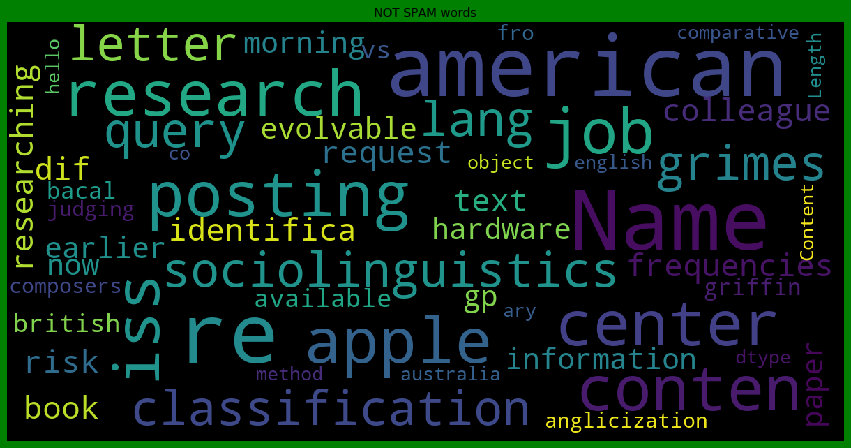

In [19]:
# NOT SPAM words in training data
Display_wordcloud(df_spam['Content'][df_spam['label']==0],"NOT SPAM")

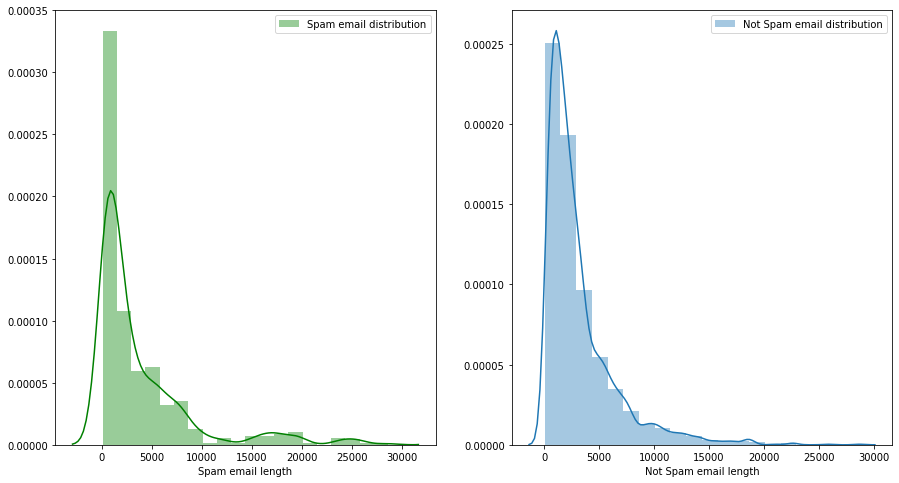

In [20]:
# Email distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_spam[df_spam['label']==1]['length'],bins=20,ax=ax[0],label='Spam email distribution',color='g')

ax[0].set_xlabel('Spam email length')
ax[0].legend()

sns.distplot(df_spam[df_spam['label']==0]['length'],bins=20,ax=ax[1],label='Not Spam email distribution')
ax[1].set_xlabel('Not Spam email length')
ax[1].legend()

plt.show()

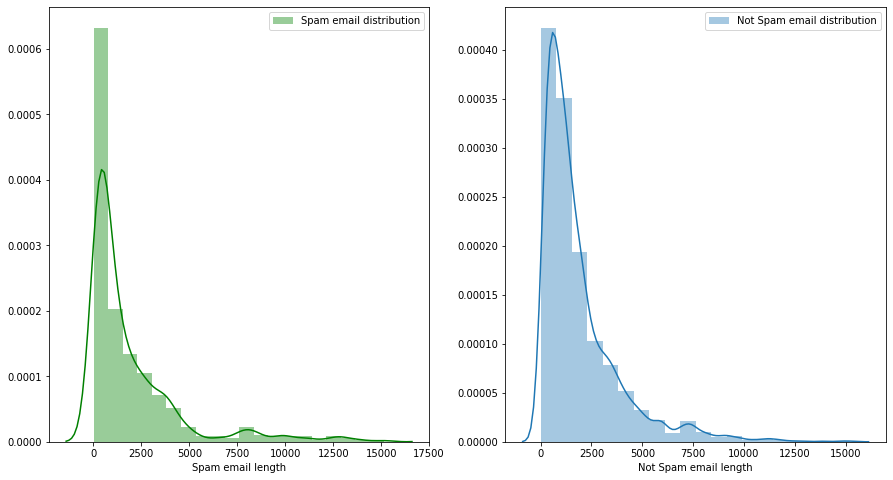

In [21]:
# Email distribution after cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_spam[df_spam['label']==1]['Clean_length'],bins=20,ax=ax[0],label='Spam email distribution',color='g')

ax[0].set_xlabel('Spam email length')
ax[0].legend()

sns.distplot(df_spam[df_spam['label']==0]['Clean_length'],bins=20,ax=ax[1],label='Not Spam email distribution')
ax[1].set_xlabel('Not Spam email length')
ax[1].legend()

plt.show()

In [22]:
# creating the TF-IDF(term frequency–inverse document frequency) vectorizer function in order to convert the tokens 
#   from the train documents into vectors so that machine can do further processing
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)

In [23]:
# Inserting vectorized values in a variable x, which will be used in training the model 
x=Tf_idf_train(df_spam['Clean_content'])

In [24]:
# checking the shape of the data which is inserted in x which will be used for model training.
print("Shape of x: ",x.shape)

# Assigning the label in y and checking it's shape
y = df_spam['label'].values
print("Shape of y: ",y.shape)

Shape of x:  (2893, 13715)
Shape of y:  (2893,)


# Model Training

In [25]:
# Importing useful libraries for model training

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Ensemble Techniques...
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Model selection libraries...
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV

# Importing some metrics we can use to evaluate our model performance.... 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

# Creating instances for different Classifiers
GBC=GradientBoostingClassifier()
RF=RandomForestClassifier()
LR=LogisticRegression()
MNB=MultinomialNB()
DT=DecisionTreeClassifier()

In [26]:
#     Putting Scikit-Learn machine learning Models in a list so that it can be used for further evaluation in loop.
models=[]
models.append(('GradientBoostingClassifier',GBC))
models.append(('RandomForestClassifier',RF))
models.append(('DecisionTreeClassifier',DT))
models.append(('LogisticRegression',LR))
models.append(('MultinomialNB()',MNB))

In [27]:
#        Function which will find best Random State and then calculate Maximum Accuracy Score corresponding to it
#                                  and print accuracy score in one go.
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score > max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state

*************************** GradientBoostingClassifier *****************************


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


Max Accuracy Score corresponding to Random State  57 is: 0.9896313364055299


Learning Score :  1.0
Accuracy Score :  0.9896313364055299
Cross Val Score :  0.9971560866810976
roc auc score :  0.9715316144874157


Classification Report:

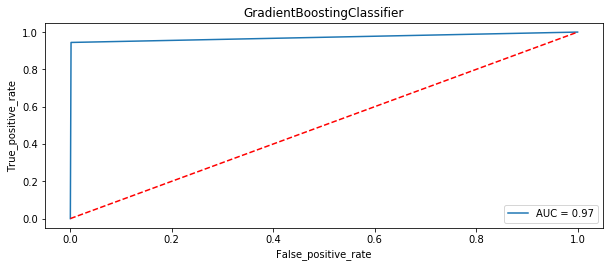

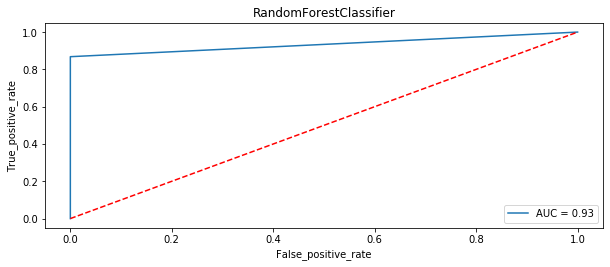

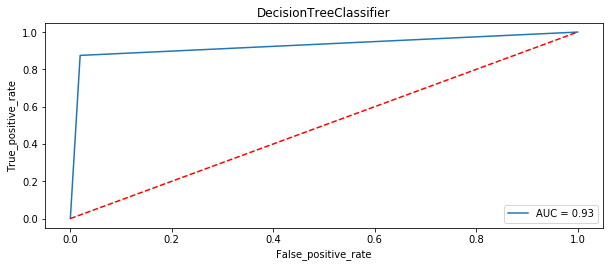

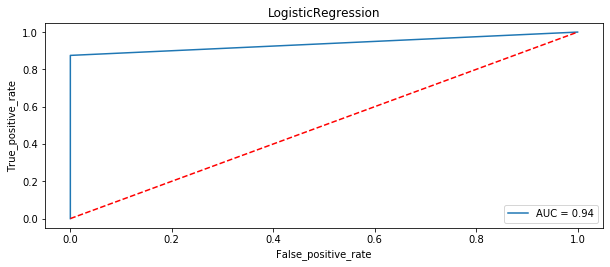

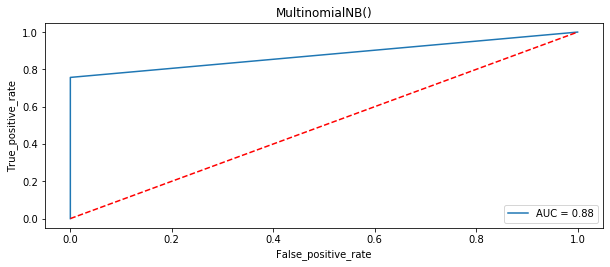

In [28]:
#     Lists to store model name, Learning score, Accuracy score, cross_val_score, Auc Roc score .
Model=[]
Score=[]
Acc_score=[]
cvs=[]
rocscore=[]
#            For Loop to Calculate Accuracy Score, Cross Val Score, Classification Report, Confusion Matrix

for name,model in models:
    print('***************************',name,'*****************************')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
    
     #        Now here I am calling a function which will calculate the max accuracy score for each model 
     #                               and return best random state.
    r_state=max_acc_score(model,x,y)
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=r_state,stratify=y)
    model.fit(x_train,y_train)
#..............Learning Score...........
    score=model.score(x_train,y_train)
    print('Learning Score : ',score)
    Score.append(score*100)
    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    Acc_score.append(acc_score*100)
#................Finding Cross_val_score..................    
    cv_score=cross_val_score(model,x,y,cv=10,scoring='roc_auc').mean()
    print('Cross Val Score : ', cv_score)
    cvs.append(cv_score*100)
    
#................Roc auc score...........................    
    false_positive_rate,true_positive_rate, thresholds=roc_curve(y_test,y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    print('roc auc score : ', roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')
#................Classification Report...........................      
    print('Classification Report:\n',classification_report(y_test,y_pred))
    print('\n')
    
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
    print('\n')
    

    
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    plt.plot(false_positive_rate,true_positive_rate,label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_positive_rate')
    plt.xlabel('False_positive_rate')
    print('\n\n')

In [29]:
# Making a Dataframe comprises of Differnt Calculated Scores :
result=pd.DataFrame({'Model': Model,'Learning Score': Score,'Accuracy Score': Acc_score,'Cross Val Score':cvs,
                     'Roc_Auc_curve':rocscore}) 
result.style.background_gradient(cmap='YlGnBu')

,Model,Learning Score,Accuracy Score,Cross Val Score,Roc_Auc_curve
0,GradientBoostingClassifier,100,98.9631,99.7156,97.1532
1,RandomForestClassifier,99.9012,97.8111,99.3837,93.4028
2,DecisionTreeClassifier,100,96.3134,91.6489,92.7831
3,LogisticRegression,98.2222,97.9263,99.9482,93.75
4,MultinomialNB(),95.6049,95.9677,99.937,87.8472


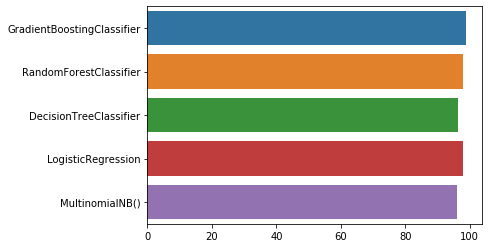

In [30]:
# visualisation of Accuracy Score
sns.barplot(y=Model,x=Acc_score)

# Using GridSearch CV

**As we can see that except Decision Tree Classifier Cross val score for each model is good and Gradient Boosting Classifier do have a good auc_roc score thus now performing GridSearchCV to get best parameters**

In [31]:
# Function for GridSearch
from sklearn.model_selection import GridSearchCV
def grid_cv(mod,parameters,scoring):
    clf = GridSearchCV(mod,parameters,scoring, cv=10)
    clf.fit(x,y)
    print(clf.best_params_)

In [32]:
#.......Grid Search for GradientBoostingClassifier......
gbc=GradientBoostingClassifier()
parameters={"learning_rate":[0.001,0.01,0.1,1],"n_estimators":[10,100,500]}
grid_cv(gbc,parameters,'f1')

{'learning_rate': 0.1, 'n_estimators': 500}


In [33]:
# checking accuracy score(using max_acc_score function defined earlier) using best parameters which calculated from gridsearchCV
clf_GBC = GradientBoostingClassifier(learning_rate=0.1,n_estimators=500)
max_acc_score(clf_GBC,x,y)

Max Accuracy Score corresponding to Random State  54 is: 0.9896313364055299




54

In [36]:
#........Grid Search for LogisticRegression....
lr=LogisticRegression()
parameters={'C': [1, 10],"solver": ["liblinear"],'penalty' : ['l1', 'l2']}
grid_cv(lr,parameters,'f1')

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [37]:
# checking accuracy score(using max_acc_score function defined earlier) using best parameters which calculated from gridsearchCV
clf_lr = LogisticRegression(C=10,solver='liblinear',penalty='l2')
max_acc_score(clf_lr,x,y)

Max Accuracy Score corresponding to Random State  63 is: 0.9942396313364056




63

In [38]:
#.......Grid Search for RandomForestClassifier.....
rf=RandomForestClassifier()
parameters={'n_estimators': [100,200,500],'max_features': ['auto','sqrt', 'log2']}
grid_cv(rf,parameters,'f1')


{'max_features': 'auto', 'n_estimators': 500}


In [39]:
# checking accuracy score(using max_acc_score function defined earlier) using best parameters which calculated from gridsearchCV
clf_rf = RandomForestClassifier(n_estimators=500,max_features='auto')
max_acc_score(clf_rf,x,y)

Max Accuracy Score corresponding to Random State  48 is: 0.9907834101382489




48

In [40]:
#.........Grid Search for MultinomialNB......
mnb=MultinomialNB()
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
grid_cv(mnb,parameters,'f1')

{'alpha': 0.1}


In [41]:
# checking accuracy score(using max_acc_score function defined earlier) using best parameters which calculated from gridsearchCV
clf_mnb = MultinomialNB(alpha=0.1)
max_acc_score(clf_mnb,x,y)

Max Accuracy Score corresponding to Random State  67 is: 1.0




67

# Training model again with best parameters

**After finding the accuracy of the models using best parameters now I am going to train these models on the basis of their best parameters and then will compare the best model....**

In [49]:
# Here I am making a function using which I am going to calculate the metric values using the models 
# along with their best parameters...
def final_evaluation(x,y,model,r_state):
    x_train,x_test,y_train,y_test=train_test_split(x, y,random_state = r_state,test_size=0.20,stratify=y)
    mod = model 
    mod.fit(x_train,y_train)
    mod.score(x_train,y_train)
    y_pred=mod.predict(x_test)
    cv_score_mod=cross_val_score(mod,x,y,cv=10,scoring='roc_auc').mean()
    print('Accuracy Score:',accuracy_score(y_test,y_pred))
    print('Cross Val Score : ', cv_score_mod)
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
    print('Classification Report:','\n',classification_report(y_test,y_pred))
    
    false_positive_rate,true_positive_rate, thresholds=roc_curve(y_test,y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    print('roc auc score : ', roc_auc)
    rocscore.append(roc_auc*100)
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.plot(false_positive_rate,true_positive_rate,label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_positive_rate')
    plt.xlabel('False_positive_rate')    

*************************Logistic Regression********************
Accuracy Score: 0.9948186528497409
Cross Val Score :  0.9996464553638059
Confusion Matrix:
 [[483   0]
 [  3  93]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.97      0.98        96

    accuracy                           0.99       579
   macro avg       1.00      0.98      0.99       579
weighted avg       0.99      0.99      0.99       579

roc auc score :  0.984375


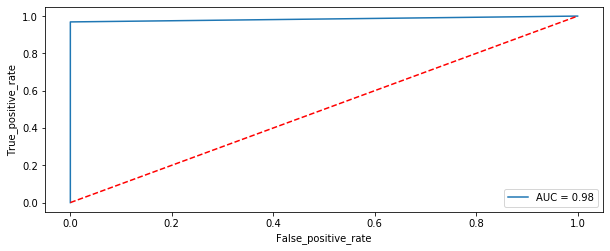

In [52]:
# ........Logistic Regression...............
clf_lr = LogisticRegression(C=10,solver='liblinear',penalty='l2')
print("*************************Logistic Regression********************")
final_evaluation(x,y,clf_lr,63)

****************************MultinomialNB**************************
Accuracy Score: 1.0
Cross Val Score :  0.9997667046740508
Confusion Matrix:
 [[483   0]
 [  0  96]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       1.00      1.00      1.00        96

    accuracy                           1.00       579
   macro avg       1.00      1.00      1.00       579
weighted avg       1.00      1.00      1.00       579

roc auc score :  1.0


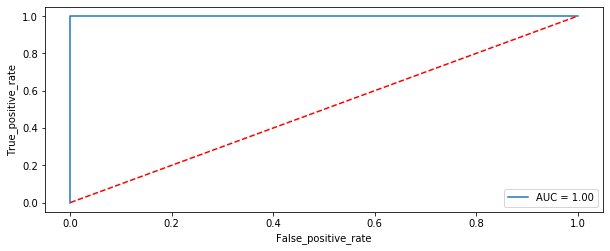

In [54]:
# .............MultinomialNB..................
clf_mnb = MultinomialNB(alpha=0.1)
print("****************************MultinomialNB**************************")
final_evaluation(x,y,clf_mnb,67)

****************************MultinomialNB**************************
Accuracy Score: 0.9913644214162349
Cross Val Score :  0.9992928392851603
Confusion Matrix:
 [[482   1]
 [  4  92]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       483
           1       0.99      0.96      0.97        96

    accuracy                           0.99       579
   macro avg       0.99      0.98      0.98       579
weighted avg       0.99      0.99      0.99       579

roc auc score :  0.9781314699792961


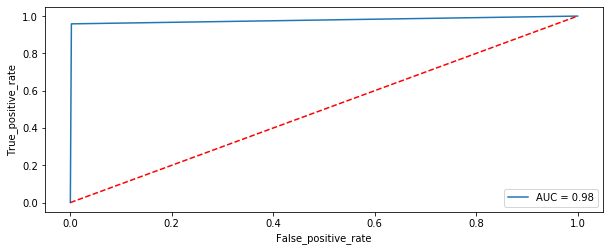

In [56]:
# .............Random Forest Classifier..................
clf_rf = RandomForestClassifier(n_estimators=500,max_features='auto')
print("****************************MultinomialNB**************************")
final_evaluation(x,y,clf_rf,48)

### After all this process conclusion is that MultinomialNB performing well because of high roc_auc score, better accuracy, better cv score after training it with best parameters...

In [57]:
# lets save the model using joblib
from sklearn.externals import joblib
joblib.dump(clf_mnb,'Project2_Spam_Detection.pkl')

['Project2_Spam_Detection.pkl']

In [60]:
# read the file using joblib
clg_mnb_from_joblib=joblib.load('Project2_Spam_Detection.pkl')
joblib_y_preds = clg_mnb_from_joblib.predict(x_test)
joblib_y_preds

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [66]:
# Printing predicted values
test=pd.DataFrame()
test['Actual values']=y_test
test['Predicted values']=joblib_y_preds
test

,Actual values,Predicted values
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
863,0,0
864,0,0
865,0,0
866,0,0


In [67]:
# Saving the Predicted values in csv file
test.to_csv('Project2_Spam_Detection.csv') 

## Conclusion :            

1) MultiNomialNB is providing better auc_roc score,accuracy ,precision,recall and f1 score as compared to other models.         2) Spam emails are less in comparison to those which are not spam.        

